In [17]:
from qiskit import QuantumCircuit, transpile
from qiskit.providers.fake_provider import FakeVigoV2
from qiskit.providers.aer import Aer
from experiment import SparsePauliTomographyExperiment as bcexperiment

backend = FakeVigoV2()

In [18]:
def executor(circuits):
    return backend.run(circuits).result().get_counts()

In [19]:
qc = QuantumCircuit(5)
qc.h(1)
qc.cx(0,1)
qc.h(0)
qc.cx(3,4)
qc.x(0)
qc.z(2)
qc.z(3)
qc.draw()

┌───┐┌───┐
q_0: ───────■──┤ H ├┤ X ├
     ┌───┐┌─┴─┐└───┘└───┘
q_1: ┤ H ├┤ X ├──────────
     ├───┤└───┘          
q_2: ┤ Z ├───────────────
     └───┘┌───┐          
q_3: ──■──┤ Z ├──────────
     ┌─┴─┐└───┘          
q_4: ┤ X ├───────────────
     └───┘

In [20]:
experiment = bcexperiment(qc, [0,1,2,3,4], backend)

In [5]:
experiment.generate(50, 50, [2,4,16])

In [6]:
experiment.run(executor)

In [7]:
experiment.analyze()

In [8]:
layer1, = experiment.analysis.noise_profiles()

In [9]:
paulis = experiment.analysis.model_terms(1,3)

In [10]:
paulis

[IYIYI, IZIYI, IZIXI, IYIXI, IXIZI, IYIZI, IXIXI, IZIZI, IXIYI]

In [11]:
layer1._term_data[paulis[2]].depths()

[2, 4, 16]

<AxesSubplot:>

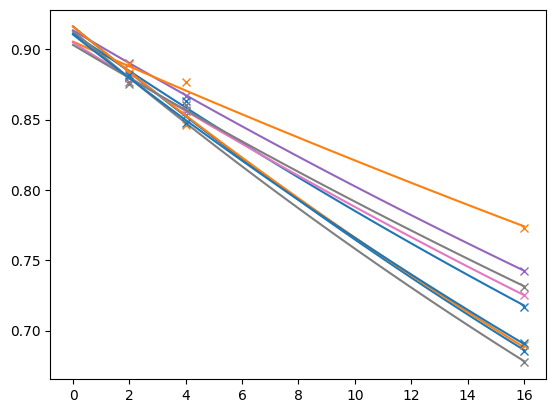

In [12]:
layer1.graph(*paulis)

<AxesSubplot:>

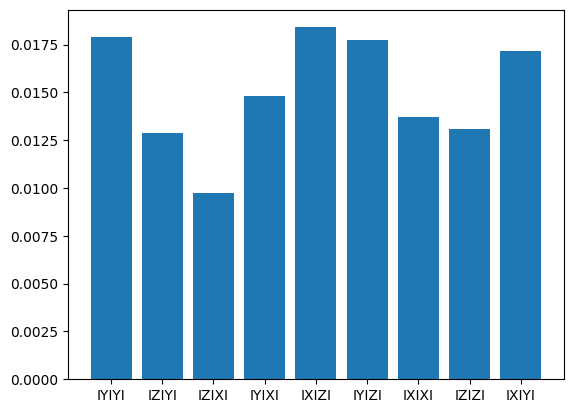

In [13]:
layer1.plot_infidelitites(*paulis)

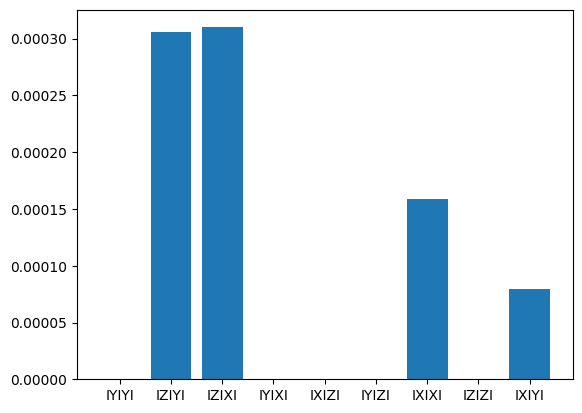

In [21]:
layer1.plot_coeffs(*paulis)